In [1]:
from scipy.io import wavfile
from scipy.io import loadmat
from scipy.ndimage.interpolation import shift
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy

The ear can be divided into three sections that process the input sound pressure: the outer, middle and inner ear. The sections are shown in the figure below 

<img src="earpic.png" width="500"/>

Sound enters the auditory pathway at the outer ear and strikes the tympanic membrane (eardrum). The vibration of the tympanic membrane in turn leads to the vibration of the three ossicles of the middle ear: the malleus, incus and stapes. The final bone in the chain, the stapes, is attached to the cochlea at the oval window (shown in above and below figures); movement at the oval window causes a pressure wave to be propagated down the cochlea.

<img src="cochlea_large.png" width="500"/>

The cochlea is a fluid-filled chamber, divided along the length into the two chambers, the scala tympani and the scala vestibuli. The basilar membrane is located along this lengthwise partition. The end that is connected to the stapes is referred to as the ‘base’ of the cochlea; at the other end is the ‘apex’. As the pressure wave propagates, the basilar membrane is displaced. The basilar membrane is thinner and stiffer at the base and gets wider and more compliant as it reaches the apex. This varying width and stiffness of the membrane creates a tonotopic system where the basilar end is most resonant to high frequencies and the apical end is most resonant to low frequencies.

The sensory receptors of the ear are the hair cells that sit on the basilar membrane, as shown in the below figure. The displacement of the basilar membrane opens ion channels, depolarizing the hair cells and releasing neurotransmitter at the synapse of the auditory nerve.

<img src="cochlearpartition.png" width="500"/>

One thing you may consider doing is developing a point process model of spiking at the auditory nerve with a generalized linear model for point processes, analogous to a logistic regression. Each regressor of the model may represent a different element that contributes to the probability of a spike at each millisecond:

 * Spontaneous Firing - Auditory neurons fire spontaneously, one element of the final generalized linear model should capture this time-invariant probability of a spike.

 * Previous Spiking - In order to capture the lower likelihood to spike soon after a previous spike, include a history of previous firing (e.g. autoregressive aspects).  The previous spiking can be considered a vector of zeros and ones, where a one represents the presence of a spike.

 * Input sound waveform - The ion channels for hair cells only open with positive displacement and close with negative displacement. In addition, since each point along the cochlea is resonant to a different frequency, auditory neurons each have a ’characteristic’ or ’best’ frequency depending on where they synapse. To model the waveform as it is seen by the auditory nerve, one may consider processing the waveform to extract the component that pertains to the characteristic frequency.  Below are some filter methods that can be used for preprocessing the audio data.  
 
 * Phase locking - auditory neurons with a characteristic frequency below 1 kHz ’phase lock’, meaning that they spike in-phase with the band-passed input waveform. Auditory neurons with a characteristic frequency above 1 kHz lose this phase locking and instead track the envelope of the band-passed waveform.  One way to consider this is by by half-wave rectifying signals, followed by low pass filtering the processed waveform (if the characteristic frequency is above 1kHz).
 
More details can be found here: http://link.springer.com/article/10.1007/s10827-009-0146-6

First we define some filter methods used for preprocessing the audio data

In [2]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

Next we define a KSplot function (copied from previous HW!)

In [3]:
# Function to find indices of all spikes
def find(a):
    # np.nonzero is the indices where the condition is true
    return np.nonzero(a == 1)[0].tolist()

# Produces a KS plot given the estimated Conditional Intensity Function
def KSplot(intensities,dN,timestep):
    spiketimes = find(dN)
    m = len(spiketimes)
    rescaledUnif = np.zeros(m-1)
    rescaledISIs = np.zeros(m-1)

    for spikeind in range(1,m):
        rescaledArrival = timestep*np.sum(intensities[spiketimes[spikeind-1]+1:spiketimes[spikeind]+1])
        rescaledISIs[spikeind-1] = rescaledArrival
        ### transform an exponential random variable with lamda=1 into a uniform[0,1] random variable.
        ### hint: use result from your homework
        unifRescaledArrival = scipy.stats.expon.cdf(rescaledArrival)     
        rescaledUnif[spikeind-1] = unifRescaledArrival
    
    sorted_rescaled_Unif = np.sort(rescaledUnif)
    empirical_rescaled_CDFvals = np.cumsum(1./(m-1) * np.ones(m-1))
    true_rescaled_CDFvals = scipy.stats.uniform.cdf(sorted_rescaled_Unif)
    plt.figure()
    plt.hist(true_rescaled_CDFvals)
    plt.title('Uniform ISI Histogram')
    plt.figure()
    plt.plot(true_rescaled_CDFvals,empirical_rescaled_CDFvals,'b')
    plt.plot((0,1),(0,1),'r-')
    plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1)+1.36/np.sqrt(m-1),'k--')
    plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1)-1.36/np.sqrt(m-1),'k--')
    plt.plot()
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.xlabel('empirical percentiles')
    plt.ylabel('fit percentiles')
    plt.title('QQ-Plot')

def BuildRegressorMtx(y,modelOrder):
    n = y.size
    regressorMatrix = np.zeros((n,modelOrder))
    regressorvector = np.zeros((1,modelOrder))
    regressorvector[0][0]=0.0

    for t in range(n):
        regressorMatrix[t] = regressorvector[0]
        regressorvector[0]=shift(regressorvector[0], -1, cval=0.0)
        regressorvector[0][modelOrder-1]=y[t]
#         for d in range(modelOrder):
#             regressorvector[0][d+1] = y[t-d-1]
#        print('t=',t,'regressorvector=',np.int_(regressorvector))

    return regressorMatrix

def Energy(signal, chfreq, Fs):
    energy = 0
    if chfreq < 1000:
        energy = np.convolve(signal, chfreq)
        plt.figure(figsize=(15,5))
        plt.plot(np.linspace(0,len(energy)/Fs,len(energy)),energy);
    else:
        energy = np.convolve(signal, chfreq)
        print (energy)
        print(np.maximum(energy, np.zeros(energy.size)))
        plt.figure(figsize=(15,5))
        plt.plot(np.linspace(0,len(energy)/Fs,len(energy)),energy);
    return energy
    

C:\Users\Jason\Anaconda3\lib\site-packages\scipy\io\wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


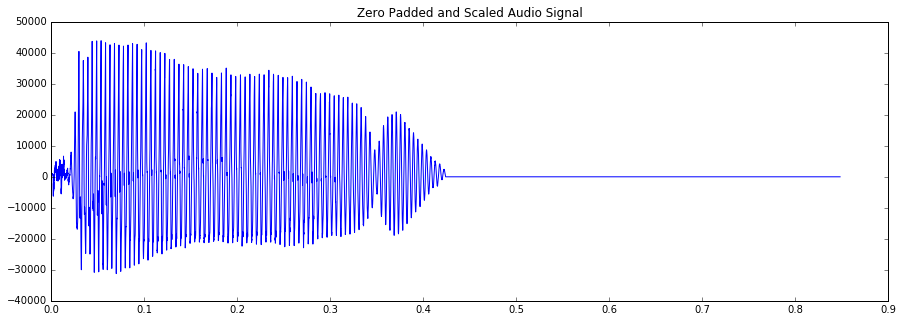

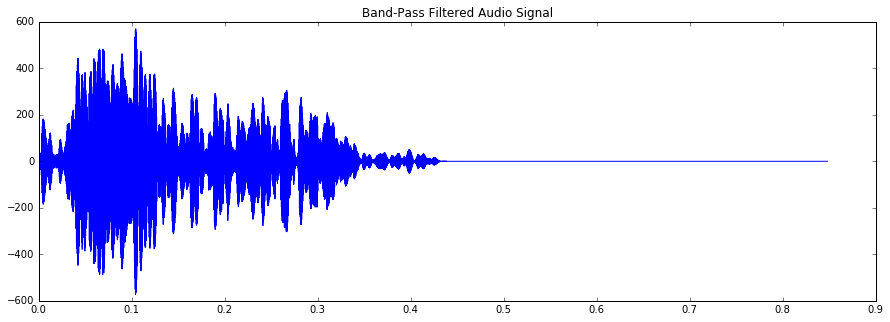

In [36]:
# Set parameters
t_ms = 848 # time duration in milliseconds
chfreq = 1250 # characteristic frequency of this neuron
J = 25 # Arbitrary for now.  Number of past spiking bins to consider

# Load audio file
(Fs,Y) = wavfile.read('dodn_sv.wav')
# Zero pad audio
zero_pad = np.zeros((np.ceil((t_ms*0.001-Y.size/Fs)*Fs),))
origsig = np.hstack((Y,zero_pad))
# Scale the audio signal
scale = 3.1623
sig = origsig*scale
# Plot audio signal
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,len(sig)/Fs,len(sig)),sig)
plt.title('Zero Padded and Scaled Audio Signal')

# Bandpass filter centered at characteristic frequency
bandwidth = 70.8518 # this is arbitrary
cutoffs=[((chfreq-(bandwidth/2))/(Fs/2)) , ((chfreq+(bandwidth/2))/(Fs/2))]
env = butter_bandpass_filter(sig, cutoffs[0], cutoffs[1], 1, order=2)
# Plot bandpass signal
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,len(env)/Fs,len(env)),env);
plt.title('Band-Pass Filtered Audio Signal')

# Load spiking data
spikes = loadmat('dodn_spikes_70spl_set7-6')['spikes']
(temp, checkwid) = spikes.shape
if checkwid > len(sig):
    spikes = spikes[:,0:len(sig)]

# newenv is 30 stacked versions of the envelope
newenv = env 
# newspikes is vectorized version of spikes
newspikes = spikes[0,:]
for r in range(1,30):
    newenv = np.vstack((newenv,env));
    newspikes = np.hstack((newspikes,spikes[r,:])) # tacking them together
newenv = newenv.T
T,_ = newenv.shape
env = newenv



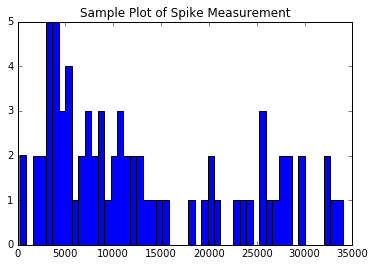

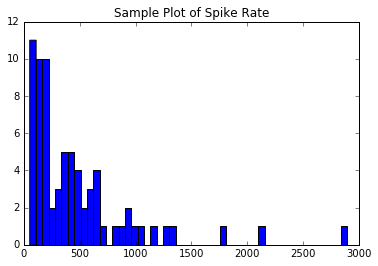

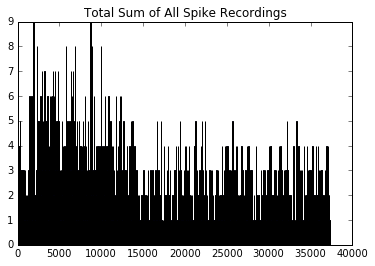

In [30]:
# Sample plot of what spikes look like
plt.figure()
plt.hist(find(spikes[0]), 50)
plt.title('Sample Plot of Spike Measurement')


# Calculating the spiking rate by using ISI
spiking = find(spikes[0])
spikingrate = np.diff(spiking)

# Sample plot of what spikingrate look like
plt.figure()
plt.hist(spikingrate, 50)
plt.title('Sample Plot of Spike Rate')

# Test for energy contribution function
# Energy(env[:, 0], chfreq, Fs)

# Compounding all spikes into one graph
spikesum = np.sum(spikes[0:30, :], axis = 0)
spikeind = find(spikesum)
spikerates = np.diff(spikeind)

plt.figure()
plt.hist(find(spikesum), 1000)
plt.title('Total Sum of All Spike Recordings')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37397
Model:                            GLM   Df Residuals:                    37386
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -520.79
Date:                Wed, 23 Nov 2016   Deviance:                       897.59
Time:                        22:13:01   Pearson chi2:                 3.66e+04
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -6.2332      0.118    -52.891      0.000        -6.464    -6.002
x1           -11.7126    563.733     -0.021      0.9

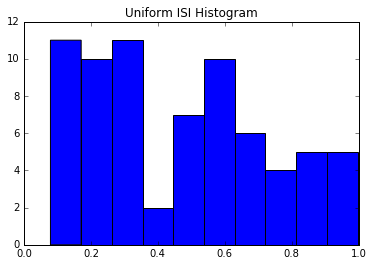

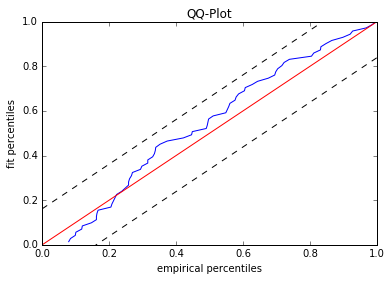

In [35]:
# Analysis on one measured train of neuron spiking
# create a binary vector of length 30,000 (e.g. 30s with 1 ms resolution). Start with all zeros
dN = np.zeros(spikes[0].size)
timestep = 1
# find the times of spikes
spiketimes = np.cumsum(spikingrate)
dN[spiketimes]=1.0

# specify the model order
model_order = 10

# build regressor matrix
R = BuildRegressorMtx(dN,model_order)
R = sm.add_constant(R)
# perform model fit
glm_model = sm.GLM(dN, R, family=sm.families.Poisson())
glm_results = glm_model.fit()
print(glm_results.summary())

loglambdas = R.dot(glm_results.params)
lambdas = np.exp(loglambdas)
KSplot(lambdas,dN,timestep)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37397
Model:                            GLM   Df Residuals:                    37386
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -7595.1
Date:                Wed, 23 Nov 2016   Deviance:                       11274.
Time:                        22:02:40   Pearson chi2:                 3.54e+04
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.1613      0.028   -111.747      0.000        -3.217    -3.106
x1            -0.0121      0.098     -0.123      0.9

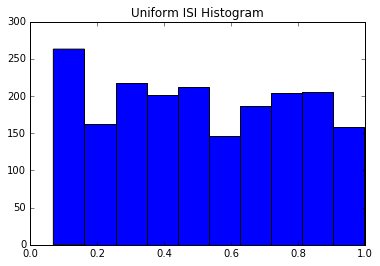

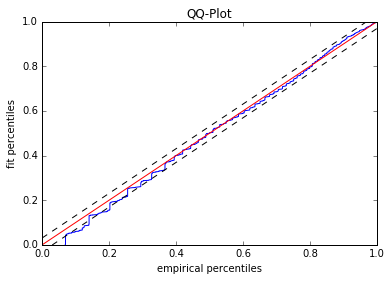

In [26]:
# analysis on compounded sum of all neuron spiking
# create a binary vector of length of spikes' size. Start with all zeros
dN = np.zeros(spikes[0].size)
timestep = 1
# find the times of spikes
spiketimes = np.cumsum(spikerates)
dN[spiketimes]=1.0

# specify the model order
model_order = 10

# build regressor matrix
R = BuildRegressorMtx(dN,model_order)
R = sm.add_constant(R)
# perform model fit
glm_model = sm.GLM(dN, R, family=sm.families.Poisson())
glm_results = glm_model.fit()
print(glm_results.summary())

loglambdas = R.dot(glm_results.params)
lambdas = np.exp(loglambdas)
KSplot(lambdas,dN,timestep)

In [27]:
def find_PNNLL(dmin, dmax,dN):
    # specify 
    dvalues = np.arange(dmin, dmax+1)
    m = dN.size
    PNNLL_AIC = np.zeros(dvalues.size)
    PNNLL_MDL = np.zeros(dvalues.size)
    PNNLL_NOPENALY = np.zeros(dvalues.size)
    Delta = 0.001
    
    for index in range(len(dvalues)):
        model_order = dvalues[index]
        # build regressor matrix
        R = BuildRegressorMtx(dN,model_order)
        R = sm.add_constant(R)
        # perform model fit
        glm_model = sm.GLM(dN, R, family=sm.families.Poisson())
        glm_results = glm_model.fit()
        loglambdas = R.dot(glm_results.params)
        lambdas = np.exp(loglambdas)
        
        # take the log of equation (16) from the point processes notes
        LL = 0.0
        for t in range(m):
            LL = LL + loglambdas[t]*dN[t] - lambdas[t]*Delta
            
        # find the negative normalized log likelihood evaluated at the optimal xhat[d]
        NNLL = -1/m * LL

        # specify AIC penalty here
        penalty_AIC = model_order/m

        # specify MDL penalty here
        penalty_MDL = model_order*np.log(m)/(2*m)

        # calculate penalized negative log likelihood
        PNNLL_AIC[index] = NNLL + penalty_AIC
        PNNLL_MDL[index] = NNLL + penalty_MDL  
        PNNLL_NOPENALY[index] = NNLL
    return dvalues, PNNLL_AIC, PNNLL_MDL, PNNLL_NOPENALY

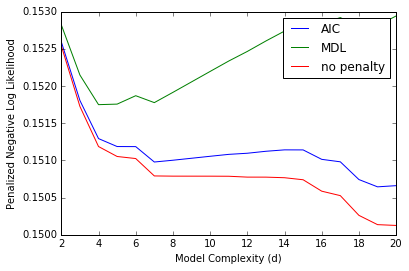

In [28]:
# create a binary vector of length of spikes' size. Start with all zeros
dN = np.zeros(spikes[0].size)
# find the times of spikes
spiketimes = np.cumsum(spikerates)
dN[spiketimes]=1.0
model_order_min = 2
model_order_max = 20

dvalues, PNNLL_AIC, PNNLL_MDL, PNNLL_NOPENALY = find_PNNLL(model_order_min, model_order_max,dN)
plt.plot(dvalues, PNNLL_AIC, label='AIC')
plt.plot(dvalues, PNNLL_MDL, label='MDL')
plt.plot(dvalues, PNNLL_NOPENALY, label = 'no penalty') 

plt.legend(loc=1)
plt.xlabel('Model Complexity (d)')
plt.ylabel('Penalized Negative Log Likelihood');

From above regularization analysis, we see that the best model order for our spiking data fit is d = 7.
As a result, we perform our fit with this model order and yield KS plot.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37397
Model:                            GLM   Df Residuals:                    37389
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -7595.2
Date:                Wed, 23 Nov 2016   Deviance:                       11274.
Time:                        22:10:10   Pearson chi2:                 3.54e+04
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.1595      0.027   -114.971      0.000        -3.213    -3.106
x1             0.3628      0.083      4.386      0.0

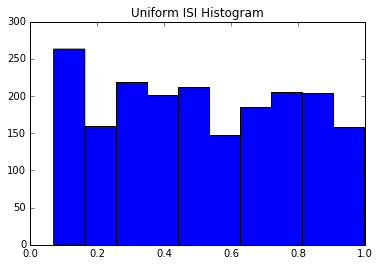

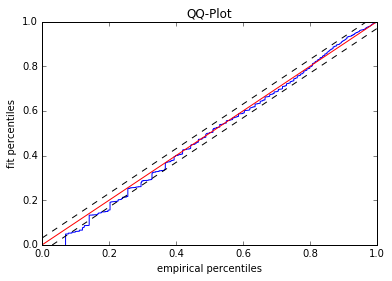

In [29]:
# analysis on compounded sum of all neuron spiking
# create a binary vector of length of spikes' size. Start with all zeros
dN = np.zeros(spikes[0].size)
timestep = 1
# find the times of spikes
spiketimes = np.cumsum(spikerates)
dN[spiketimes]=1.0

# specify the model order
model_order = 7

# build regressor matrix
R = BuildRegressorMtx(dN,model_order)
R = sm.add_constant(R)
# perform model fit
glm_model = sm.GLM(dN, R, family=sm.families.Poisson())
glm_results = glm_model.fit()
print(glm_results.summary())

loglambdas = R.dot(glm_results.params)
lambdas = np.exp(loglambdas)
KSplot(lambdas,dN,timestep)